In [33]:
from datetime import datetime
import pandas as pd
%run utils.ipynb
import polars as pl


In [34]:
dos_df, fuzzy_df, attack_free_df=load_datasets_using_pd()

# Exploratory Data Analysis

## Common Methods

In [35]:
def show_shape_info_of_data(data):
    print("Data Shape")
    print("*" * 40)
    print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")
    print("\nInfo")
    print("*" * 40)
    info_dict={
        "Column": data.columns,
        "Data Type": data.dtypes,
        "Null Count": data.isnull().sum(),
        "Unique Count":data.nunique()}
    info_df = pd.DataFrame(info_dict)
    print(info_df.to_string(index=False))


In [36]:
def merge_bytes_into_one_column(cols,new_column_name,data):
    data[new_column_name] = ""
    for col in cols:
        data[new_column_name]+=data[col]
    return data


In [37]:
def convert_timestamp_to_datetime(col_to_be_added_name,existing_col_name, data):
    data[col_to_be_added_name] = pd.to_datetime(data[existing_col_name], unit='s')
    return data

In [38]:
def divide_datetime_into_hour_day_month_year(existing_col_name,data):
    data['year'] = data[existing_col_name].dt.year
    data['month'] = data[existing_col_name].dt.month
    data['day'] = data[existing_col_name].dt.day
    data['hour']=data[existing_col_name].dt.hour

    return data


In [39]:
def convert_hex_to_int(value):
    if isinstance(value, str):
        return int(value, 16)
    return value  

In [40]:
def show_unique_hour_day_month_year_of_timestamp(data):
    for d in ['day','month','year','hour']:
        print(d,data[d].unique())

## DoS

In [41]:
show_shape_info_of_data(dos_df)

Data Shape
****************************************
Rows: 3665770, Columns: 12

Info
****************************************
     Column Data Type  Null Count  Unique Count
  timestamp   float64           0       3665770
      canId    object           0            27
        dlc     int64           0             2
      byte0    object           0           108
      byte1    object           0            71
      byte2    object       31188            75
      byte3    object       31188            26
      byte4    object       31188           190
      byte5    object       31188           256
      byte6    object       31188            75
      byte7    object       31188           256
updatedFlag    object           0             2


In [42]:
dos_df=convert_timestamp_to_datetime("datetime","timestamp", dos_df)
dos_df=divide_datetime_into_hour_day_month_year("datetime",dos_df)

In [43]:
show_unique_hour_day_month_year_of_timestamp(dos_df)


day [3]
month [11]
year [2016]
hour [18 19]


In [44]:
dos_df["hour"].value_counts()

hour
19    2271240
18    1394530
Name: count, dtype: int64

In [45]:
col="canId"
dos_df["canid_int"] = dos_df[col].apply(convert_hex_to_int)

In [46]:
#dos_df["canid_int"].value_counts()

In [47]:
col="dlc"
dos_df[col].unique()

array([8, 2])

In [48]:
col="updatedFlag"
dos_df[col].value_counts()

updatedFlag
R    3078249
T     587521
Name: count, dtype: int64

In [49]:
bytes_col_list=[col for col in dos_df.columns if col.startswith("byte")]
dos_df=merge_bytes_into_one_column(bytes_col_list,"merged_bytes",dos_df)

In [50]:
col="merged_bytes"
dos_df[col].nunique()

66913

In [51]:
dos_df["updatedFlag"].isna().sum()

np.int64(0)

### Insights about DoS Attack

- Data was collected in November 3, 2016 and in two hours.
- CAN ID
    - Most rows are with id 0. It can be DoS attack.
    - Data with 160 and 161 are smallest number after O. When we think about DoS attack logic, they can also be considered as attack. 
    - **But the problem is 160 and 161 id exist so rare.**
- DLC
    - It shows length of data field in bytes.
    - It is either 2 or 8.
- Byte0 ... Byte7
    - it shows data field in eight columns in bytes.
    - First three byte have no null count. Last 5 byte have more than 30k null count. 
    - When you merge 8 columns into one columns, you can seee 66K unique data field.
    - **The problem is we have either 2 byte or 8 byte data. How can 5 byte null be possible?**
- Flag
    - It can be T or R
        - T-> injected message
        - R-> normal message
    - Normal message is nearly five times bigger than injected message.


## Fuzzy

In [52]:
show_shape_info_of_data(fuzzy_df)

Data Shape
****************************************
Rows: 3838859, Columns: 12

Info
****************************************
     Column Data Type  Null Count  Unique Count
  timestamp   float64           0       3838859
      canId    object           0          2048
        dlc     int64           0             4
      byte0    object           0           256
      byte1    object           0           256
      byte2    object       34382           256
      byte3    object       34382           256
      byte4    object       34382           256
      byte5    object       87833           256
      byte6    object       87836           256
      byte7    object       87836           256
updatedFlag    object           0             2


In [53]:
fuzzy_df=convert_timestamp_to_datetime("datetime","timestamp", fuzzy_df)
fuzzy_df=divide_datetime_into_hour_day_month_year("datetime",fuzzy_df)

In [54]:
show_unique_hour_day_month_year_of_timestamp(fuzzy_df)

day [3]
month [11]
year [2016]
hour [17 18 19]


In [55]:
col="canId"
fuzzy_df["canid_int"] = fuzzy_df[col].apply(convert_hex_to_int)

In [56]:
col="canid_int"
#fuzzy_df[col].value_counts()[:20]

In [57]:
col="dlc"
fuzzy_df[col].unique()

array([5, 8, 2, 6])

In [58]:
fuzzy_df=merge_bytes_into_one_column(bytes_col_list,"merged_bytes",fuzzy_df)

In [59]:
col="merged_bytes"
fuzzy_df[col].nunique()

560012

In [60]:
fuzzy_df.head()

,timestamp,canId,dlc,byte0,byte1,byte2,byte3,byte4,byte5,byte6,byte7,updatedFlag,datetime,year,month,day,hour,canid_int,merged_bytes
0,1.478196e+09,02b0,5,ff,7f,00,05,49,NaN,NaN,NaN,R,2016-11-03 17:55:21.905735970,2016,11,3,17,688,NaN
1,1.478196e+09,0002,8,00,00,00,00,00,01,07,15,R,2016-11-03 17:55:21.908437014,2016,11,3,17,2,0000000000010715
2,1.478196e+09,0153,8,00,21,10,ff,00,ff,00,00,R,2016-11-03 17:55:21.908675909,2016,11,3,17,339,002110ff00ff0000
3,1.478196e+09,0130,8,19,80,00,ff,fe,7f,07,60,R,2016-11-03 17:55:21.909414053,2016,11,3,17,304,198000fffe7f0760
4,1.478196e+09,0131,8,17,80,00,00,65,7f,07,9f,R,2016-11-03 17:55:21.909660101,2016,11,3,17,305,17800000657f079f


### Insights about Fuzzy Attack
- All data was collected November 3, 2016 and in 3 hours. it is same as DoS Attack.
- There can be groupings as well.
- In attack free data, dlc can be 2 or 8. In fuzzy attack it can be 2,5,6,and 8. 5 and 6 can be quickly find as malicious.
- When we merge bytes columns, fuzzy attack have 560k unique data. Four unique dlc may create this huge unique data number
- 

## Attack Free

In [61]:


show_shape_info_of_data(attack_free_df)

Data Shape
****************************************
Rows: 988871, Columns: 12

Info
****************************************
   Column Data Type  Null Count  Unique Count
timestamp   float64           0        988871
    canId    object           0            27
frameType     int64           0             1
      dlc     int64           0             3
    byte0    object           0           256
    byte1    object           0           256
    byte2    object       10129           256
    byte3    object       10129           256
    byte4    object       10129           256
    byte5    object       60735           256
    byte6    object       60735           227
    byte7    object       60735           256


In [62]:
col="timestamp"
attack_free_df=convert_timestamp_to_datetime("datetime","timestamp", attack_free_df)
attack_free_df=divide_datetime_into_hour_day_month_year("datetime",attack_free_df)

In [63]:
show_unique_hour_day_month_year_of_timestamp(attack_free_df)


day [14]
month [11]
year [2016]
hour [11]


In [64]:
col="canId"
attack_free_df["canid_int"] = attack_free_df[col].apply(convert_hex_to_int)


In [65]:
#attack_free_df["canid_int"].value_counts()

In [66]:
attack_free_canid_set=set(attack_free_df["canid_int"].unique())
dos_canid_set=set(dos_df["canid_int"].unique())

print("only in dos",dos_canid_set-attack_free_canid_set)
print("only in attack free",attack_free_canid_set-dos_canid_set)

only in dos {np.int64(0)}
only in attack free {np.int64(688)}


In [67]:
col="frameType"
attack_free_df[col].unique()

array([0])

In [68]:
col="dlc"
attack_free_df[col].unique()

array([8, 5, 2])

In [69]:
bytes_col_list=[col for col in attack_free_df.columns if col.startswith("byte")]
attack_free_df=merge_bytes_into_one_column(bytes_col_list,"merged_bytes",attack_free_df)

In [70]:
bytes_col_list

['byte0', 'byte1', 'byte2', 'byte3', 'byte4', 'byte5', 'byte6', 'byte7']

In [71]:
#attack_free_df.head()

In [72]:
col="merged_bytes"
attack_free_df[col].nunique()

275180

### Insights about Attack Free
- Total rows in attack free dataset is nearly one third of dos and fuzzy attack.
- Attack Free data was collected November 14, 2016 and in one hour.
- Can Id
    - There can be grouping of ids such as some ids occur 50k, some 25k, some 5k.
- Frame Type
    - I named 000 as frame_type but not sure whether it is frame_type or not because it can be rtr that show it is standart can frame or extended can frame.
    - Assume it is really frame type. It is value only is 000 and data frame not a remote frame.
- DLC
    - it can be 2,5 or 8. It probably shows diverse data.
- Byte0 ... Btye7
    - When you merge 8 columns into one columns, you can seee 275k unique data field.
    



## General Insights

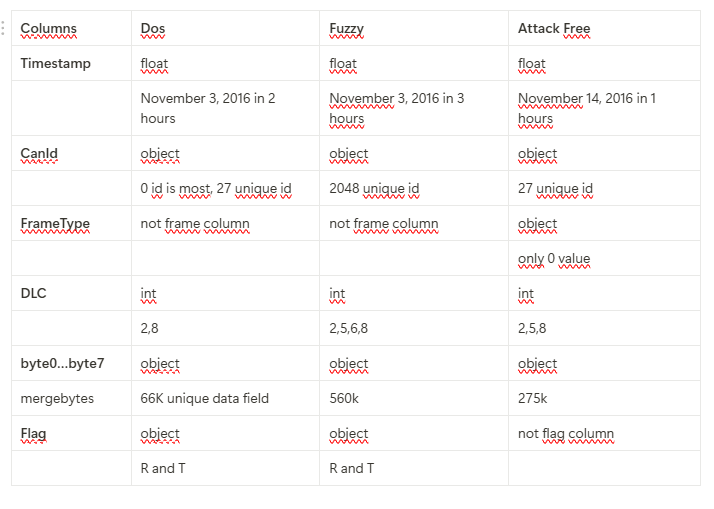